In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession, Window, functions as F
from pyspark.sql.functions import countDistinct, col, date_format
import numpy as np
import pyspark.sql.functions as func
from pyspark.sql.functions import sum, avg, count, lag, date_sub, split
from pyspark.sql.window import Window
from pyspark.sql.types import (
    StringType,
    LongType,
    DoubleType,
    StructField,
    StructType,
    FloatType
)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read all curated csv files from feature engineering
tech_df = pd.read_csv('../data/curated/tech_df.csv', index_col=[0])
furniture_df = pd.read_csv('../data/curated/furniture_df.csv', index_col=[0])
hobby_df = pd.read_csv('../data/curated/hobby_df.csv', index_col=[0])
all_df = pd.read_csv('../data/curated/all_df.csv', index_col=[0])

# Read test data
tech_df_test = pd.read_csv('../data/curated/tech_df_test.csv', index_col=[0])
furniture_df_test = pd.read_csv('../data/curated/furniture_df_test.csv', index_col=[0])
hobby_df_test = pd.read_csv('../data/curated/hobby_df_test.csv', index_col=[0])
all_df_test = pd.read_csv('../data/curated/all_df_test.csv', index_col=[0])

In [3]:
def get_train_test_data(train_df, test_df):
    '''
    Set up train and test data to be used for modelling.
    Standardized numeric data to avoid bias in the data set.
    '''
    
    
    X_train = train_df.loc[:, ~train_df.columns.isin(['merchant_abn', 
                                                      'merchant_sa2',
                                                      'order_year_month', 
                                                      'total_revenue'])]
    y_train = train_df.loc[:, train_df.columns.isin(['total_revenue'])]
    X_test = test_df.loc[:, ~test_df.columns.isin(['merchant_abn', 
                                                   'merchant_sa2',
                                                   'order_year_month',
                                                   'total_revenue'])]
    y_test = test_df.loc[:, test_df.columns.isin(['total_revenue'])]

    # one hot encoded order_month
    enc = pd.get_dummies(train_df['order_month'], prefix='order_month')
    test_enc = pd.get_dummies(test_df['order_month'], prefix='order_month')
    for m in [1, 9, 10, 11, 12]:
        test_enc[f'order_month{str(m)}'] = 0
    
    #Standardise column
    std_col = ['trx_count', 'distinct_consumer', 'new_consumer', 'male_buyer',
               'female_buyer', 'take_rate', 'growth_perc', 
               'median_age_of_earners_years', 'median_aud', 
               'gini_coefficient_coef', 'males_age_20_44', 
               'females_age_20_44', 'males_age_45_60', 'females_age_45_60']
    X_train_std = X_train[std_col].astype(float).apply(zscore)
    X_test_std = X_test[std_col].astype(float).apply(zscore)
    

    scaler_y_train = StandardScaler().fit(y_train[['total_revenue']])
    y_train = np.ravel(scaler_y_train.transform(y_train[['total_revenue']]))

    scaler_y_test = StandardScaler().fit(y_test[['total_revenue']])
    y_test = np.ravel(scaler_y_test.transform(y_test[['total_revenue']]))
    
    X_train = pd.concat([X_train_std, enc], axis=1)
    X_test = pd.concat([X_test_std, test_enc], axis=1)
    
    return X_train, X_test, y_train, y_test, scaler_y_train, scaler_y_test


In [28]:
# Start Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/06 18:01:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/06 18:01:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/06 18:01:37 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [47]:
tech_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4501 entries, 0 to 4500
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   merchant_abn                 4501 non-null   int64  
 1   order_year_month             4501 non-null   object 
 2   merchant_sa2                 4501 non-null   float64
 3   order_month                  4501 non-null   int64  
 4   trx_count                    4501 non-null   int64  
 5   active_days                  4501 non-null   int64  
 6   distinct_consumer            4501 non-null   int64  
 7   new_consumer                 4501 non-null   int64  
 8   take_rate                    4501 non-null   float64
 9   male_buyer                   4501 non-null   int64  
 10  female_buyer                 4501 non-null   int64  
 11  total_revenue                4501 non-null   float64
 12  growth_perc                  4501 non-null   float64
 13  median_age_of_earn

In [80]:
import geopandas
sa2_bound = geopandas.read_file(f'../data/abs/sa2_boundaries.gml')

In [81]:
sa2_state = sa2_bound[['sa2_maincode_2016','state_name_2016']]

In [82]:
sa2_state['sa2_maincode_2016'] = sa2_state.sa2_maincode_2016.astype(float)
sa2_state = sa2_state.rename(columns = {'sa2_maincode_2016': 'merchant_sa2',
                                        'state_name_2016': 'state'})

---
### Ranking System Model for Technology Segment

In [4]:
X_train, X_test, y_train, y_test, scaler_y_train, scaler_y_test = get_train_test_data(tech_df, tech_df_test)

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4501 entries, 0 to 4500
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   trx_count                    4501 non-null   float64
 1   distinct_consumer            4501 non-null   float64
 2   new_consumer                 4501 non-null   float64
 3   male_buyer                   4501 non-null   float64
 4   female_buyer                 4501 non-null   float64
 5   take_rate                    4501 non-null   float64
 6   growth_perc                  4501 non-null   float64
 7   median_age_of_earners_years  4501 non-null   float64
 8   median_aud                   4501 non-null   float64
 9   gini_coefficient_coef        4501 non-null   float64
 10  males_age_20_44              4501 non-null   float64
 11  females_age_20_44            4501 non-null   float64
 12  males_age_45_60              4501 non-null   float64
 13  females_age_45_60 

In [6]:
lr = LinearRegression().fit(X_train, y_train)

In [7]:
y_pred = lr.predict(X_test)

In [8]:
y_test_actual = np.ravel(scaler_y_test.inverse_transform([y_test]))
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [9]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test_actual, y_pred_actual)))
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(y_test_actual, y_pred_actual))
print('R^2 Score:', metrics.r2_score(y_test_actual, y_pred_actual))

Root Mean Squared Error: 1314.5358242685738
Root Mean Absolute Percentage Error: 7.579738747393599
R^2 Score: 0.7172577889617362


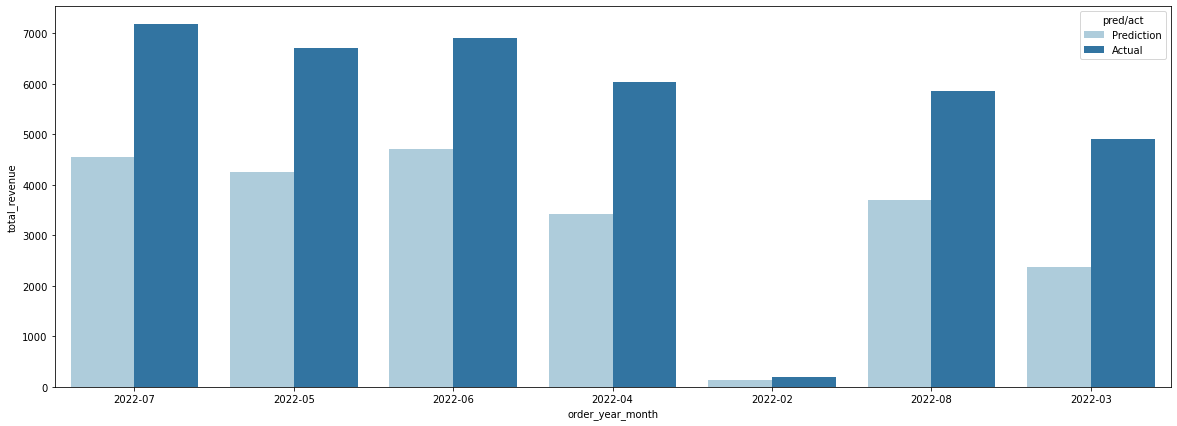

In [10]:
df1 = tech_df_test[['merchant_abn', 'order_year_month']]
df1['total_revenue'] = y_pred_actual
df1['pred/act'] = 'Prediction'

df2 = tech_df_test[['merchant_abn', 'order_year_month']]
df2['total_revenue'] = tech_df_test['total_revenue']
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

df_vis = df_visualise[df_visualise['merchant_abn'] == 41271931352]
plt.figure(figsize=(20, 7))
sns.barplot(
    x="order_year_month", y="total_revenue", hue="pred/act", data=df_vis, ci=95, 
    palette="Paired"
)
plt.show()

---
### Random Forest Regression

max_features = 20: 	 R2-score: 0.9064821789018387 	RMSE: 0.3021457299731483
max_features = 22: 	 R2-score: 0.912820438373374 	RMSE: 0.2912098853173789
max_features = 24: 	 R2-score: 0.9127538839937512 	RMSE: 0.2912114901417795
max_features = 26: 	 R2-score: 0.913258539672021 	RMSE: 0.28990407068195767


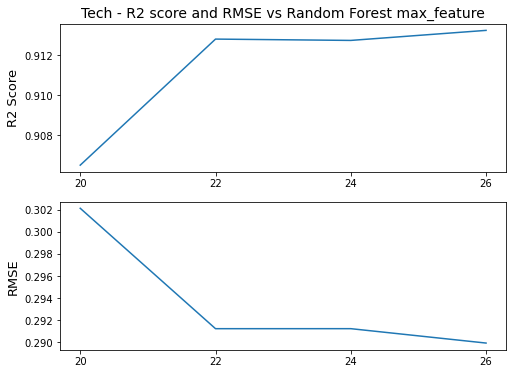

In [13]:
# Tune max_feature
rmse = []
r2 = []
mfs = [20, 22, 24, 26]

for mf in mfs:
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    rmse.append(abs(np.mean(rmse_cv)))
    
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    r2.append(np.mean(r2_cv))
    
    print(f"max_features = {mf}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))


# Visualise RMSE and R2 for different max_feature value
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(mfs)), r2, label='R2')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Tech - R2 score and RMSE vs Random Forest max_feature', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(mfs)), rmse, label='RMSE')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_tech_hype_tuning_maxf.png')

When max_feature = 26, the model has highest r2 score and lowest RMSE.

n_estimators = 50: 	 R2-score: 0.9091767103554353 	RMSE: 0.29739738566887475
n_estimators = 100: 	 R2-score: 0.913258539672021 	RMSE: 0.28990407068195767
n_estimators = 200: 	 R2-score: 0.9158051224057069 	RMSE: 0.2860099529845464
n_estimators = 300: 	 R2-score: 0.9147390690569737 	RMSE: 0.2882614891007211


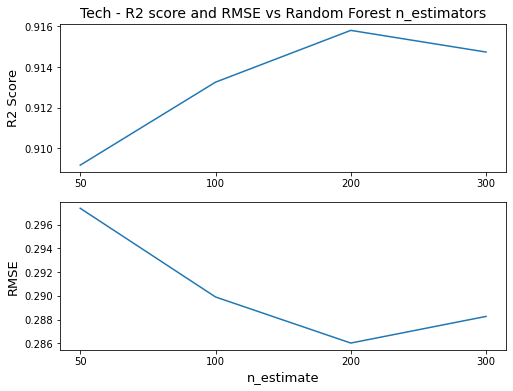

In [14]:
# Visualise RMSE and R2 for different n_estimator value
rmse = []
r2 = []
ests = (50, 100, 200, 300)


for n_est in ests:
    rf = RandomForestRegressor(n_estimators=n_est, random_state = 42, 
                               max_features=26)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    
    print(f"n_estimators = {n_est}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))
    rmse.append(abs(np.mean(rmse_cv)))
    r2.append(np.mean(r2_cv))
    
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(ests)), r2, label='R2')
plt.xticks(range(len(ests)), ests)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Tech - R2 score and RMSE vs Random Forest n_estimators', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(ests)), rmse, label='RMSE')
plt.xticks(range(len(ests)), ests)
plt.xlabel('n_estimate', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_tech_hype_tuning_nest.png')

When n_estimate = 200, the model has highest r2 score and lowest RMSE.

In [16]:
rf = RandomForestRegressor(n_estimators = 200, random_state = 42, 
                           max_features=26)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=26, n_estimators=200, random_state=42)

In [17]:
y_pred = rf.predict(X_test)

In [18]:
y_test_actual = np.ravel(scaler_y_test.inverse_transform([y_test]))
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [19]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test_actual, y_pred_actual)))
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(y_test_actual, y_pred_actual))
print('R^2 Score:', metrics.r2_score(y_test_actual, y_pred_actual))

Root Mean Squared Error: 883.0725216156969
Root Mean Absolute Percentage Error: 0.5568457836380193
R^2 Score: 0.8724035652256693


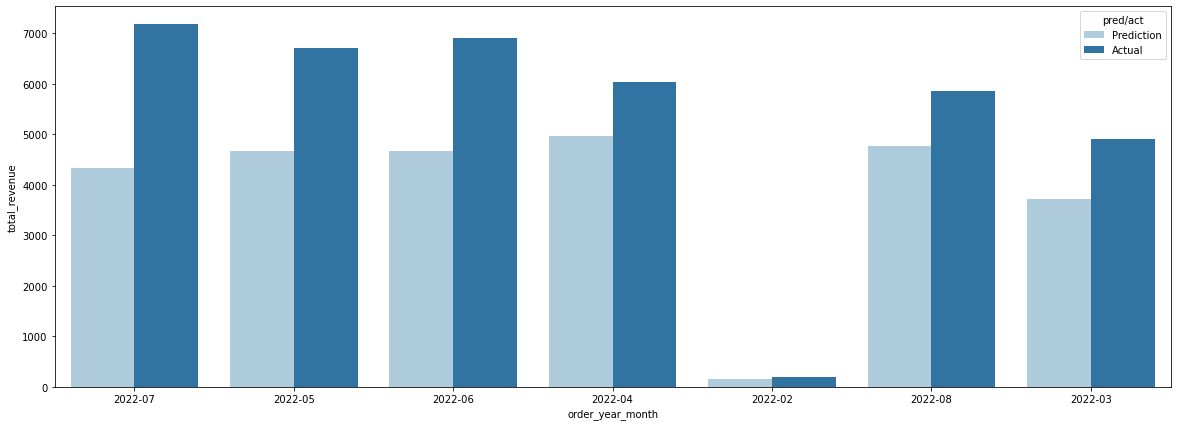

In [20]:
df1 = tech_df_test[['merchant_abn', 'order_year_month']]
df1['total_revenue'] = y_pred_actual
df1['pred/act'] = 'Prediction'

df2 = tech_df_test[['merchant_abn', 'order_year_month']]
df2['total_revenue'] = tech_df_test['total_revenue']
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

df_vis = df_visualise[df_visualise['merchant_abn'] == 41271931352]
plt.figure(figsize=(20, 7))
sns.barplot(
    x="order_year_month", y="total_revenue", hue="pred/act", data=df_vis, ci=95, 
    palette="Paired"
)
plt.savefig(f'../plots/rf_tech_predvsact_41271931352.png')

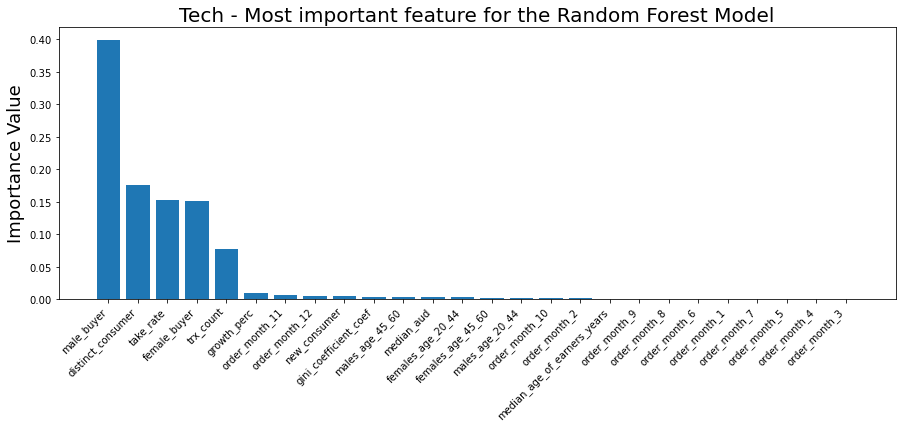

In [21]:
# visualise feature importance value
importances = list(rf.feature_importances_)
df_imp = (pd.DataFrame({'feature':X_train.columns.tolist(), 'importances':importances})
            .sort_values(by='importances', ascending=False).reset_index(drop=True))

df_imp_top30 = df_imp[:30]
plt.figure(figsize=(15,5))
plt.bar('feature', 'importances', orientation = 'vertical', data=df_imp_top30)
plt.xticks(rotation=45, ha="right")
plt.xlabel("", fontsize=18)
plt.ylabel("Importance Value", fontsize=18)
plt.title("Tech - Most important feature for the Random Forest Model", fontsize=20)
plt.savefig(f'../plots/rf_tech_important_feat.png', bbox_inches='tight')


In [117]:
col = ['merchant_abn', 'merchant_sa2','female_buyer', 
       'male_buyer', 'order_year_month']
df1 = tech_df_test[col]
df1['total_revenue'] = y_pred_actual
df1['pred/act'] = 'Prediction'

df2 = tech_df_test[col]
df2['total_revenue'] = tech_df_test['total_revenue']
df2['pred/act'] = 'Actual'

df = pd.concat([df1, df2],axis=0)
df = df.merge(sa2_state, on='merchant_sa2', how='left')

df_pred = df[df['pred/act'] == "Prediction"]
df_actual = df[df['pred/act'] == "Actual"]

gb_col = ['merchant_abn', 'state']
pred_select = (df_pred.groupby(gb_col).agg(total_revenue=('total_revenue','sum'),
                                           male=('male_buyer','sum'),
                                           female=('female_buyer','sum'))
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

actual_select = (df_actual.groupby(gb_col).agg(total_revenue=('total_revenue','sum'),
                                           male=('male_buyer','sum'),
                                           female=('female_buyer','sum'))
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

display(pd.DataFrame(pred_select['state'].value_counts()))
display(pd.DataFrame(actual_select['state'].value_counts()))
print('Male/Female monthly buyer:', (pred_select['male'].mean(), pred_select['female'].mean()))

# Get top 10 merchants by calculating their monthly total revenue
# Merchant ranking based on prediction
pred_merchant_abn = pred_select['merchant_abn'].tolist()
actual_merchant_abn = actual_select['merchant_abn'].tolist()

[pred in actual_merchant_abn for pred in pred_merchant_abn]

,state
South Australia,7
Western Australia,3


,state
South Australia,6
Western Australia,4


Male/Female monthly buyer: (3658.1, 3606.2)


[True, True, True, True, True, True, True, True, True, False]

9/10 of the predicted merchants are inside the actual top 10 rank highest revenue merchant.

---
### Ranking System Model for Furniture Segment

In [17]:
X_train, X_test, y_train, y_test, scaler_y_train, scaler_y_test = get_train_test_data(furniture_df, furniture_df_test)

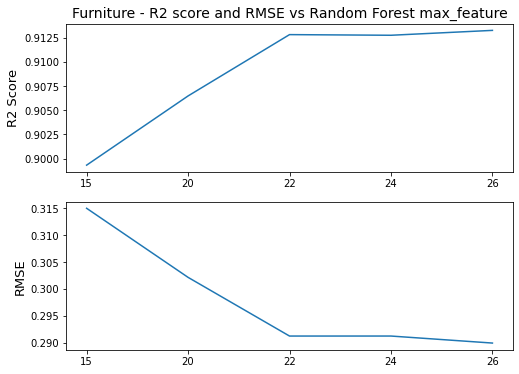

In [120]:
# Tune max_feature evaluate between 10-14
rmse = []
r2 = []
mfs = [15, 20, 22, 24, 26]
for mf in mfs:
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    rmse.append(abs(np.mean(rmse_cv)))
    
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    r2.append(np.mean(r2_cv))

# Visualise RMSE and R2 for different max_feature value
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(mfs)), r2, label='R2')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Furniture - R2 score and RMSE vs Random Forest max_feature', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(mfs)), rmse, label='RMSE')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_furniture_hype_tuning_maxf.png')

When max_feature = 14, the model has highest r2 score and lowest RMSE.

n_estimators = 50: 	 R2-score: 0.9091767103554353 	RMSE: 0.29739738566887475
n_estimators = 100: 	 R2-score: 0.913258539672021 	RMSE: 0.28990407068195767
n_estimators = 200: 	 R2-score: 0.9158051224057069 	RMSE: 0.2860099529845464
n_estimators = 300: 	 R2-score: 0.9147390690569737 	RMSE: 0.2882614891007211


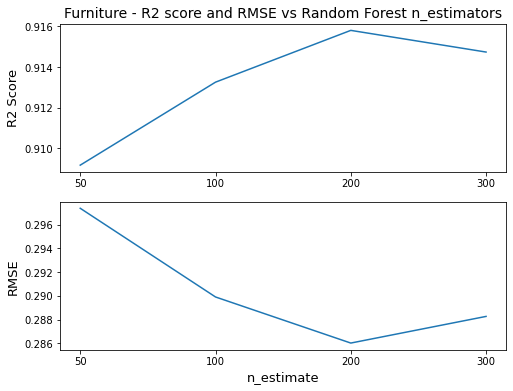

In [122]:
# Visualise RMSE and R2 for different n_estimator value
rmse = []
r2 = []
ests = (50, 100, 200, 300)


for n_est in ests:
    rf = RandomForestRegressor(n_estimators=n_est, random_state = 42, 
                               max_features=26)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    
    print(f"n_estimators = {n_est}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))
    rmse.append(abs(np.mean(rmse_cv)))
    r2.append(np.mean(r2_cv))
    
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(ests)), r2, label='R2')
plt.xticks(range(len(ests)), ests)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Furniture - R2 score and RMSE vs Random Forest n_estimators', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(ests)), rmse, label='RMSE')
plt.xticks(range(len(ests)), ests)
plt.xlabel('n_estimate', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_furniture_hype_tuning_nest.png')

When n_estimate = 100, the model has highest r2 score and lowest RMSE.

In [18]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, 
                           max_features=26)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [19]:
y_test_actual = np.ravel(scaler_y_test.inverse_transform([y_test]))
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [20]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test_actual, y_pred_actual)))
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(y_test_actual, y_pred_actual))
print('R^2 Score:', metrics.r2_score(y_test_actual, y_pred_actual))

Root Mean Squared Error: 566.5472220740058
Root Mean Absolute Percentage Error: 2.7845124303443294
R^2 Score: 0.9149577869781609


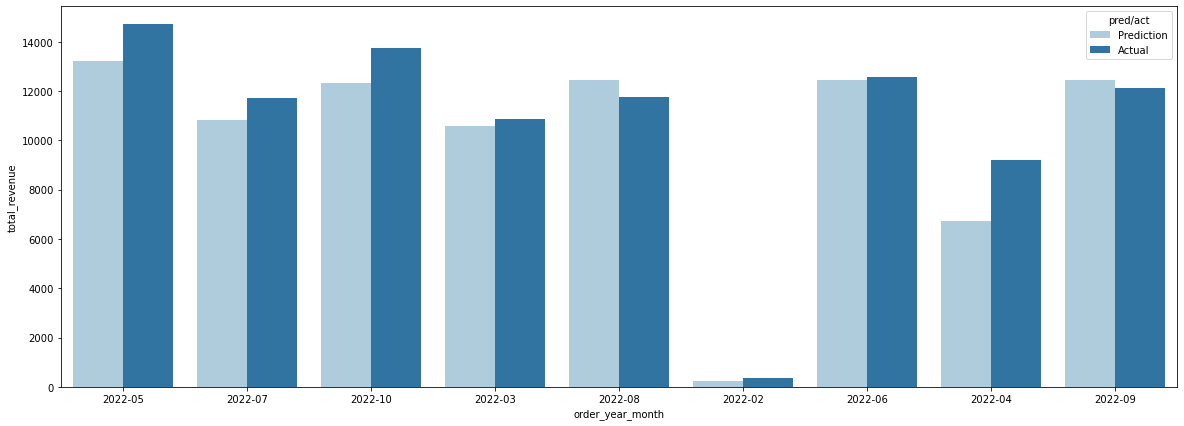

In [21]:
df1 = furniture_df_test[['merchant_abn', 'order_year_month']]
df1['total_revenue'] = y_pred_actual
df1['pred/act'] = 'Prediction'

df2 = furniture_df_test[['merchant_abn', 'order_year_month']]
df2['total_revenue'] = furniture_df_test['total_revenue']
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

df_vis = df_visualise[df_visualise['merchant_abn'] == 79827781481]
plt.figure(figsize=(20, 7))
sns.barplot(
    x="order_year_month", y="total_revenue", hue="pred/act", data=df_vis, ci=95, 
    palette="Paired"
)
plt.savefig(f'../plots/rf_furniture_predvsact_79827781481.png')

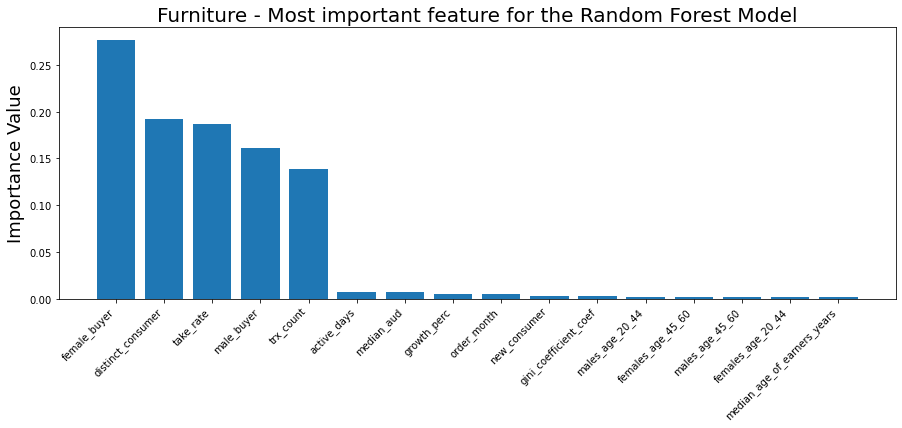

In [22]:
# visualise feature importance value
importances = list(rf.feature_importances_)
df_imp = (pd.DataFrame({'feature':X_train.columns.tolist(), 'importances':importances})
            .sort_values(by='importances', ascending=False).reset_index(drop=True))

df_imp_top30 = df_imp[:30]
plt.figure(figsize=(15,5))
plt.bar('feature', 'importances', orientation = 'vertical', data=df_imp_top30)
plt.xticks(rotation=45, ha="right")
plt.xlabel("", fontsize=18)
plt.ylabel("Importance Value", fontsize=18)
plt.title("Furniture - Most important feature for the Random Forest Model", fontsize=20)
plt.savefig(f'../plots/rf_furniture_important_feat.png', bbox_inches='tight')


In [23]:
# Get top 10 merchants by calculating their monthly total revenue
# Merchant ranking based on prediction
df_pred = df_visualise[df_visualise['pred/act'] == "Prediction"]
df_actual = df_visualise[df_visualise['pred/act'] == "Actual"]

pred_select = (df_pred.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

pred_merchant_abn = pred_select['merchant_abn'].tolist()

actual_select = (df_actual.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

actual_merchant_abn = actual_select['merchant_abn'].tolist()

[pred in actual_merchant_abn for pred in pred_merchant_abn]

[True, True, True, True, True, True, True, True, False, True]

9/10 of the predicted merchants are inside the actual top 10 rank highest revenue merchant.

---
### Ranking System Model for Hobby and Toys Shop Segment

In [123]:
X_train, X_test, y_train, y_test, scaler_y_train, scaler_y_test = get_train_test_data(hobby_df, hobby_df_test)

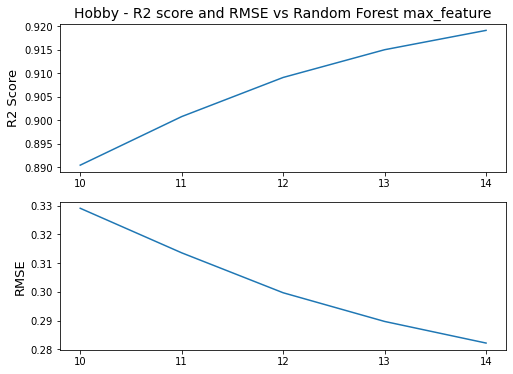

In [32]:
# Tune max_feature evaluate between 10-14
rmse = []
r2 = []
for mf in [15, 20, 22, 24, 26]:
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    rmse.append(abs(np.mean(rmse_cv)))
    
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    r2.append(np.mean(r2_cv))

# Visualise RMSE and R2 for different max_feature value
mfs = range(10, 15)
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(mfs)), r2, label='R2')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Hobby - R2 score and RMSE vs Random Forest max_feature', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(mfs)), rmse, label='RMSE')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_hobby_hype_tuning_maxf.png')

When max_feature = 14, the model has highest r2 score and lowest RMSE.

In [ ]:
# Visualise RMSE and R2 for different n_estimator value
rmse = []
r2 = []
ests = (10, 100, 300, 500)


for n_est in ests:
    rf = RandomForestRegressor(n_estimators=n_est, random_state = 42, 
                               max_features=14)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    
    print(f"n_estimators = {n_est}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))
    rmse.append(abs(np.mean(rmse_cv)))
    r2.append(np.mean(r2_cv))
    
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(ests)), r2, label='R2')
plt.xticks(range(len(ests)), ests)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Hobby - R2 score and RMSE vs Random Forest n_estimators', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(ests)), rmse, label='RMSE')
plt.xticks(range(len(ests)), ests)
plt.xlabel('n_estimate', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_hobby_hype_tuning_nest.png')

When n_estimate = 100, the model has highest r2 score and lowest RMSE.

In [25]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 42, 
                           max_features=14)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [26]:
y_test_actual = np.ravel(scaler_y_test.inverse_transform([y_test]))
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [27]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test_actual, y_pred_actual)))
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(y_test_actual, y_pred_actual))
print('R^2 Score:', metrics.r2_score(y_test_actual, y_pred_actual))

Root Mean Squared Error: 1457.3934059095582
Root Mean Absolute Percentage Error: 1.7019917697999438
R^2 Score: 0.7431168788764778


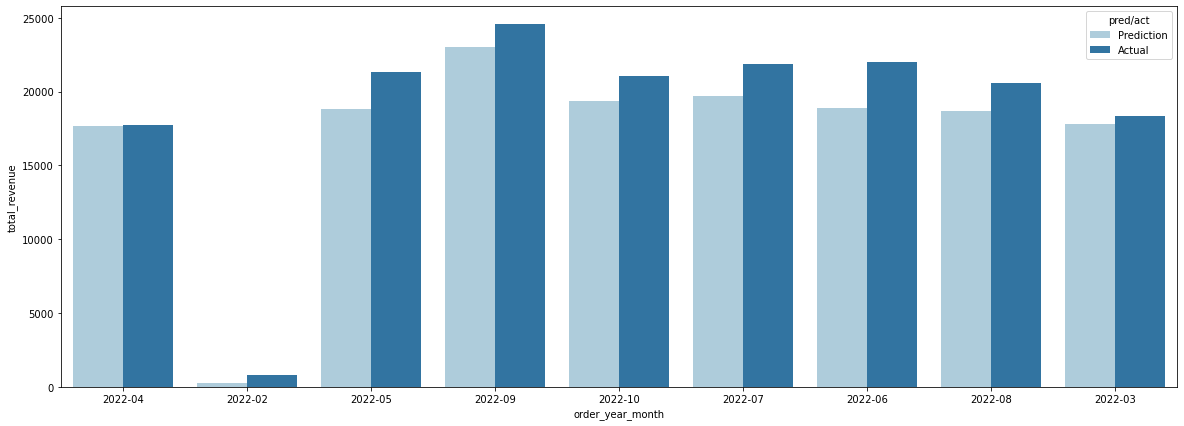

In [28]:
df1 = hobby_df_test[['merchant_abn', 'order_year_month']]
df1['total_revenue'] = y_pred_actual
df1['pred/act'] = 'Prediction'

df2 = hobby_df_test[['merchant_abn', 'order_year_month']]
df2['total_revenue'] = hobby_df_test['total_revenue']
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

df_vis = df_visualise[df_visualise['merchant_abn'] == 63123845164]
plt.figure(figsize=(20, 7))
sns.barplot(
    x="order_year_month", y="total_revenue", hue="pred/act", data=df_vis, ci=95, 
    palette="Paired"
)
plt.savefig(f'../plots/rf_hobby_predvsact_63123845164.png')

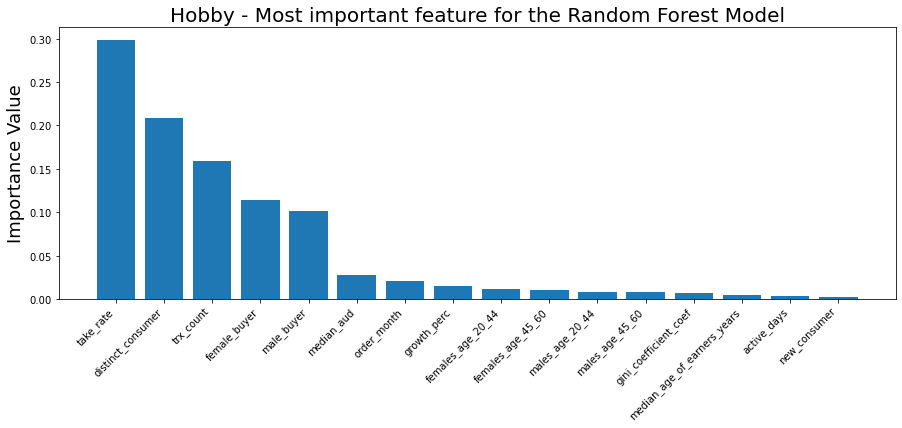

In [29]:
# visualise feature importance value
importances = list(rf.feature_importances_)
df_imp = (pd.DataFrame({'feature':X_train.columns.tolist(), 'importances':importances})
            .sort_values(by='importances', ascending=False).reset_index(drop=True))

df_imp_top30 = df_imp[:30]
plt.figure(figsize=(15,5))
plt.bar('feature', 'importances', orientation = 'vertical', data=df_imp_top30)
plt.xticks(rotation=45, ha="right")
plt.xlabel("", fontsize=18)
plt.ylabel("Importance Value", fontsize=18)
plt.title("Hobby - Most important feature for the Random Forest Model", fontsize=20)
plt.savefig(f'../plots/rf_hobby_important_feat.png', bbox_inches='tight')


In [30]:
# Get top 10 merchants by calculating their monthly total revenue
# Merchant ranking based on prediction
df_pred = df_visualise[df_visualise['pred/act'] == "Prediction"]
df_actual = df_visualise[df_visualise['pred/act'] == "Actual"]

pred_select = (df_pred.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

pred_merchant_abn = pred_select['merchant_abn'].tolist()

actual_select = (df_actual.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(10))

actual_merchant_abn = actual_select['merchant_abn'].tolist()

[pred in actual_merchant_abn for pred in pred_merchant_abn]

[True, True, True, True, True, True, False, True, True, False]

8/10 of the predicted merchants are inside the actual top 10 rank highest revenue merchant.

---
### Overall Top 100 merchants

In [124]:
X_train, X_test, y_train, y_test, scaler_y_train, scaler_y_test = get_train_test_data(all_df, all_df_test)

In [127]:
# Tune max_feature evaluate between 12-14
rmse = []
r2 = []
for mf in [22, 24, 26]:
    rf = RandomForestRegressor(random_state = 42, max_features=mf)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    rmse.append(abs(np.mean(rmse_cv)))
    
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    r2.append(np.mean(r2_cv))
    print(f"n_estimators = {n_est}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))

# Visualise RMSE and R2 for different max_feature value
mfs = range(12, 15)
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(mfs)), r2, label='R2')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Hobby - R2 score and RMSE vs Random Forest max_feature', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(mfs)), rmse, label='RMSE')
plt.xticks(range(len(mfs)), mfs)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_all_hype_tuning_maxf.png')

KeyboardInterrupt: 

In [ ]:
# Visualise RMSE and R2 for different n_estimator value
rmse = []
r2 = []
ests = (100, 200, 250)


for n_est in ests:
    rf = RandomForestRegressor(n_estimators=n_est, random_state = 42, 
                               max_features=26)
    rmse_cv = cross_val_score(rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
    r2_cv = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
    
    print(f"n_estimators = {n_est}: \t", 'R2-score:', np.mean(r2_cv), 
          '\tRMSE:', abs(np.mean(rmse_cv)))
    rmse.append(abs(np.mean(rmse_cv)))
    r2.append(np.mean(r2_cv))
    
plt.figure(figsize=(8,6))
plt.subplot(2, 1, 1)
plt.plot(range(len(ests)), r2, label='R2')
plt.xticks(range(len(ests)), ests)
plt.ylabel('R2 Score', fontsize=13)
plt.title('Hobby - R2 score and RMSE vs Random Forest n_estimators', fontsize=14)

plt.subplot(2, 1, 2)
plt.plot(range(len(ests)), rmse, label='RMSE')
plt.xticks(range(len(ests)), ests)
plt.xlabel('n_estimate', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.savefig(f'../plots/rf_all_hype_tuning_nest.png')

In [128]:
rf = RandomForestRegressor(n_estimators = 200, random_state = 42, 
                           max_features=26)

In [129]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [130]:
y_test_actual = np.ravel(scaler_y_test.inverse_transform([y_test]))
y_pred_actual = np.ravel(scaler_y_test.inverse_transform([y_pred]))

In [131]:
print('Root Mean Squared Error:', 
      np.sqrt(metrics.mean_squared_error(y_test_actual, y_pred_actual)))
print('Root Mean Absolute Percentage Error:', 
      metrics.mean_absolute_percentage_error(y_test_actual, y_pred_actual))
print('R^2 Score:', metrics.r2_score(y_test_actual, y_pred_actual))

Root Mean Squared Error: 1570.6153715864862
Root Mean Absolute Percentage Error: 2.1429600090908996
R^2 Score: 0.7104921501852028


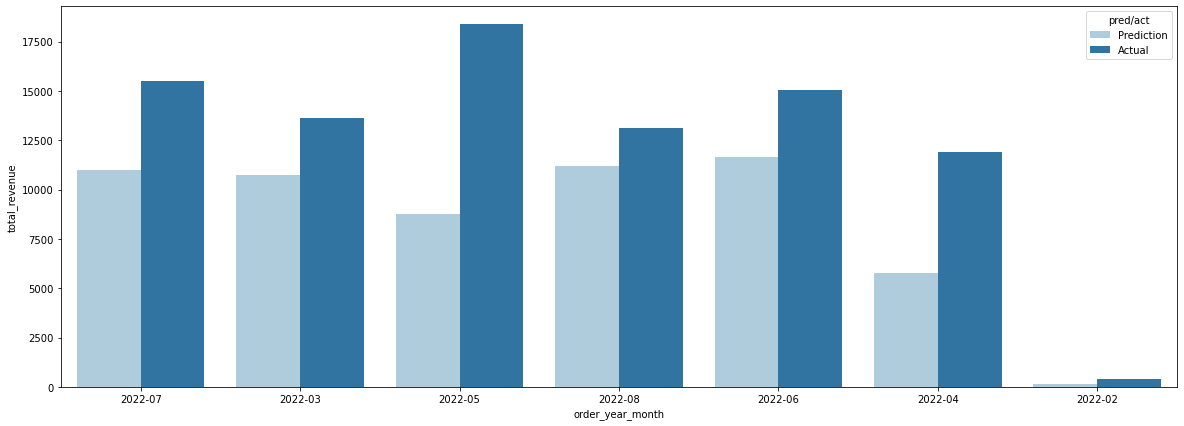

In [132]:
df1 = all_df_test[['merchant_abn', 'order_year_month']]
df1['total_revenue'] = y_pred_actual
df1['pred/act'] = 'Prediction'

df2 = all_df_test[['merchant_abn', 'order_year_month']]
df2['total_revenue'] = all_df_test['total_revenue']
df2['pred/act'] = 'Actual'

df_visualise = pd.concat([df1, df2],axis=0)

df_vis = df_visualise[df_visualise['merchant_abn'] == 79827781481]
plt.figure(figsize=(20, 7))
sns.barplot(
    x="order_year_month", y="total_revenue", hue="pred/act", data=df_vis, ci=95, 
    palette="Paired"
)
plt.savefig(f'../plots/rf_all_predvsact_63123845164.png')

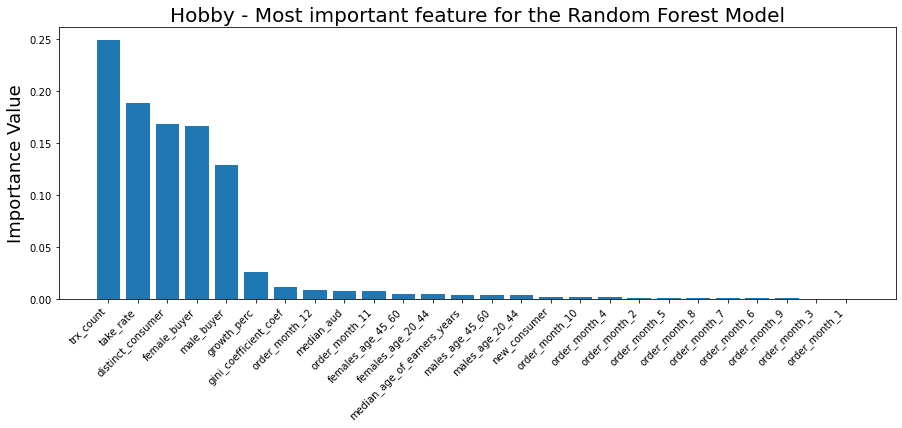

In [133]:
# visualise feature importance value
importances = list(rf.feature_importances_)
df_imp = (pd.DataFrame({'feature':X_train.columns.tolist(), 'importances':importances})
            .sort_values(by='importances', ascending=False).reset_index(drop=True))

df_imp_top30 = df_imp[:30]
plt.figure(figsize=(15,5))
plt.bar('feature', 'importances', orientation = 'vertical', data=df_imp_top30)
plt.xticks(rotation=45, ha="right")
plt.xlabel("", fontsize=18)
plt.ylabel("Importance Value", fontsize=18)
plt.title("Hobby - Most important feature for the Random Forest Model", fontsize=20)
plt.savefig(f'../plots/rf_all_important_feat.png', bbox_inches='tight')


In [134]:
# Get top 10 merchants by calculating their monthly total revenue
# Merchant ranking based on prediction
df_pred = df_visualise[df_visualise['pred/act'] == "Prediction"]
df_actual = df_visualise[df_visualise['pred/act'] == "Actual"]

pred_select = (df_pred.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(100))

pred_merchant_abn = pred_select['merchant_abn'].tolist()

actual_select = (df_actual.groupby('merchant_abn').sum('total_revenue')
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(100))

actual_merchant_abn = actual_select['merchant_abn'].tolist()



In [164]:
merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")

In [165]:
@F.udf(StringType())
def normalize_tags(col):
    return col.replace("(", "[").replace(")", "]")[1:-1]

merchants = merchants.withColumn("tags", normalize_tags(F.col("tags")))

def clean_tags(df):
    '''
    Split elements in tags into:
    - categories
    - revenue_level
    - take_rate
    '''
    df = (df
              .withColumn("categories", 
                          F.regexp_extract("tags", "(?<=\[)(.*?)(?=\])", 1))
              .withColumn("revenue_level", 
                          F.regexp_extract("tags", "(?<=,\s\[)([a-e]+?)(?=\],)", 1))
              .withColumn("take_rate", 
                          F.regexp_extract("tags", "(?<=\[take rate: )(.*?)(?=\])", 1))
              .withColumn("take_rate", 
                          F.col("take_rate").astype(FloatType()))
         )
    return df

merchants = clean_tags(merchants)

@F.udf(StringType())
def clean_string(col):
    '''
    Convert every character to lower case
    '''
    col = col.lower()
    return " ".join(col.split())

merchants = merchants.withColumn("categories", clean_string(F.col("categories")))

In [166]:
merchants = merchants.toPandas()

In [172]:
col = ['merchant_abn', 'merchant_sa2','female_buyer', 
       'male_buyer', 'order_year_month']
df1 = all_df_test[col]
df1['total_revenue'] = y_pred_actual
df1['pred/act'] = 'Prediction'

df2 = all_df_test[col]
df2['total_revenue'] = all_df_test['total_revenue']
df2['pred/act'] = 'Actual'

df = pd.concat([df1, df2],axis=0)
df = df.merge(sa2_state, on='merchant_sa2', how='left')

df = df.merge(merchants[['merchant_abn','categories']], on='merchant_abn', 
              how='left')

df_pred = df[df['pred/act'] == "Prediction"]
df_actual = df[df['pred/act'] == "Actual"]

gb_col = ['merchant_abn', 'state', 'categories']
pred_select = (df_pred.groupby(gb_col).agg(total_revenue=('total_revenue','sum'),
                                           male=('male_buyer','sum'),
                                           female=('female_buyer','sum'))
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(100))

actual_select = (df_actual.groupby(gb_col).agg(total_revenue=('total_revenue','sum'),
                                           male=('male_buyer','sum'),
                                           female=('female_buyer','sum'))
                 .reset_index(drop=False).sort_values('total_revenue', 
                                                      ascending=False)
                 .head(100))

display(pd.DataFrame(pred_select['state'].value_counts()))
display(pd.DataFrame(actual_select['state'].value_counts()))
print('Male/Female monthly buyer:', (pred_select['male'].mean(), pred_select['female'].mean()))

# Get top 10 merchants by calculating their monthly total revenue
# Merchant ranking based on prediction
pred_merchant_abn = pred_select['merchant_abn'].tolist()
actual_merchant_abn = actual_select['merchant_abn'].tolist()


display(pd.DataFrame(pred_select['categories'].value_counts()))
display(pd.DataFrame(actual_select['categories'].value_counts()))


correct = 0
for pred in pred_merchant_abn:
    if pred in actual_merchant_abn:
        correct += 1
print(f"{correct}/100")

,state
South Australia,59
Western Australia,20
Victoria,15
Tasmania,3
Queensland,2
New South Wales,1


,state
South Australia,56
Western Australia,21
Victoria,18
Queensland,3
Tasmania,1
New South Wales,1


Male/Female monthly buyer: (4952.66, 4839.06)


,categories
"watch, clock, and jewelry repair shops",10
tent and awning shops,9
"cable, satellite, and other pay television and radio services",9
"digital goods: books, movies, music",9
"computers, computer peripheral equipment, and software",8
"gift, card, novelty, and souvenir shops",7
"books, periodicals, and newspapers",6
"furniture, home furnishings and equipment shops, and manufacturers, except appliances",6
motor vehicle supplies and new parts,5
"computer programming , data processing, and integrated systems design services",5


,categories
tent and awning shops,11
"lawn and garden supply outlets, including nurseries",8
motor vehicle supplies and new parts,6
artist supply and craft shops,6
"books, periodicals, and newspapers",6
"computers, computer peripheral equipment, and software",6
"gift, card, novelty, and souvenir shops",6
"watch, clock, and jewelry repair shops",5
"florists supplies, nursery stock, and flowers",5
"computer programming , data processing, and integrated systems design services",5


70/100


In [171]:
df

,merchant_abn,merchant_sa2,female_buyer,male_buyer,order_year_month,total_revenue,pred/act,state,categories
0,10618089367,216021413.0,73,87,2022-06,1873.021053,Prediction,Victoria,"stationery, office supplies and printing and w..."
1,12434006854,203011035.0,23,37,2022-06,877.719340,Prediction,Victoria,"stationery, office supplies and printing and w..."
2,12771097467,202021028.0,9,9,2022-05,1176.056213,Prediction,Victoria,motor vehicle supplies and new parts
3,13401263605,509021245.0,6,5,2022-05,296.786098,Prediction,Western Australia,"florists supplies, nursery stock, and flowers"
4,15253672771,603031073.0,7,2,2022-02,219.665946,Prediction,Tasmania,"gift, card, novelty, and souvenir shops"
...,...,...,...,...,...,...,...,...,...
47739,99272161508,216021413.0,1,0,2022-07,29.159445,Actual,Victoria,"hobby, toy and game shops"
47740,85684792409,103021068.0,2,0,2022-03,58.508177,Actual,New South Wales,health and beauty spas
47741,65175701530,106011113.0,1,0,2022-03,103.662430,Actual,New South Wales,"furniture, home furnishings and equipment shop..."
47742,61639583117,501021016.0,0,1,2022-07,63.456108,Actual,Western Australia,motor vehicle supplies and new parts


In [ ]:
merchants.